Epoch 1/10, Train Accuracy: 43.43%, Validation Accuracy: 37.50%
Epoch 2/10, Train Accuracy: 58.95%, Validation Accuracy: 45.00%
Epoch 3/10, Train Accuracy: 68.09%, Validation Accuracy: 48.50%
Epoch 4/10, Train Accuracy: 73.09%, Validation Accuracy: 54.00%
Epoch 5/10, Train Accuracy: 74.84%, Validation Accuracy: 54.00%
Epoch 6/10, Train Accuracy: 80.35%, Validation Accuracy: 69.00%
Epoch 7/10, Train Accuracy: 83.48%, Validation Accuracy: 61.00%
Epoch 8/10, Train Accuracy: 83.85%, Validation Accuracy: 46.50%
Epoch 9/10, Train Accuracy: 85.86%, Validation Accuracy: 44.00%
Epoch 10/10, Train Accuracy: 87.61%, Validation Accuracy: 62.00%


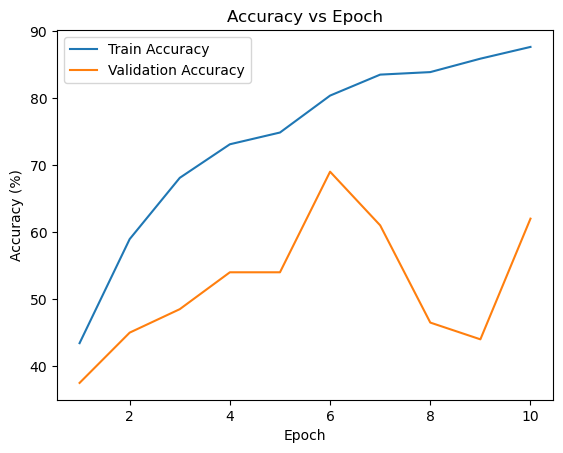

Final Validation Accuracy: 62.00%


In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# Path to GTZAN dataset
data_dir = r'C:\Users\ykj2\Desktop\Data\images_original' #to avoid backslash treated as unicode, you put r for 'raw'

# Parameters
batch_size = 32
num_epochs = 10
train_split = 0.8  # 80% train, 20% validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet152 expects 224x224 images
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class GTZANDataset(Dataset):
    def __init__(self, data_pairs, transform=None):
        self.data_pairs = data_pairs
        self.transform = transform

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, label = self.data_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Create data pairs
def create_data_pairs(data_dir):
    data_pairs = []
    genres = os.listdir(data_dir)  # List of genres (folder names)
    genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}  # Map genres to indices
    for genre in genres:
        genre_path = os.path.join(data_dir, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                if file.endswith('.png'):
                    file_path = os.path.join(genre_path, file)
                    data_pairs.append((file_path, genre_to_idx[genre]))
    return data_pairs, genre_to_idx

data_pairs, genre_to_idx = create_data_pairs(data_dir)

# Extract labels for stratification
labels = [label for _, label in data_pairs]

# Split data into train and validation sets
train_pairs, val_pairs = train_test_split(data_pairs, test_size=1-train_split, stratify= labels if len(set(labels)) > 1 else None)

# Create DataLoaders
train_dataset = GTZANDataset(train_pairs, transform=transform)
val_dataset = GTZANDataset(val_pairs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize ResNet152 Model
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(genre_to_idx))  # Adjust output for genres
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation function
def train_and_evaluate(num_epochs):
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_accuracies, val_accuracies

# Train the model
train_accuracies, val_accuracies = train_and_evaluate(num_epochs)

# Plot accuracies
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# Print final validation accuracy
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [ ]:
import os

# Base directory containing genre folders
data_dir = r'C:\Users\ykj2\Desktop\Data\genres_original'

# List to store all file paths and their genres
data_pairs = []

# Iterate through each genre folder
for genre in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            if file.endswith(('.wav', '.mp3')):
                data_pairs.append((file_path, genre))  # Add file path and genre

# Print the collected file paths and their genres
for path, genre in data_pairs:
    print(f"File: {path}, Genre: {genre}")



File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00000.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00001.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00002.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00003.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00004.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00005.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00006.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00007.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00008.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00009.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.00010.wav, Genre: blues
File: C:\Users\ykj2\Desktop\Data\genres_original\blues\blues.0001

C:\Users\ykj2\AppData\Local\Temp\ipykernel_136432\631690274.py:36: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
c:\Users\ykj2\AppData\Local\anaconda3\envs\test\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed to process C:\Users\ykj2\Desktop\Data\genres_original\jazz\jazz.00054.wav: 
Genre: blues, Number of Files Processed: 100
Genre: classical, Number of Files Processed: 100
Genre: country, Number of Files Processed: 100
Genre: disco, Number of Files Processed: 100
Genre: hiphop, Number of Files Processed: 100
Genre: jazz, Number of Files Processed: 99
Genre: metal, Number of Files Processed: 100
Genre: pop, Number of Files Processed: 100
Genre: reggae, Number of Files Processed: 100
Genre: rock, Number of Files Processed: 100
Epoch 1/20, Train Accuracy: 28.90%, Validation Accuracy: 39.67%
Epoch 2/20, Train Accuracy: 66.67%, Validation Accuracy: 70.33%
Epoch 3/20, Train Accuracy: 81.12%, Validation Accuracy: 73.33%
Epoch 4/20, Train Accuracy: 93.71%, Validation Accuracy: 75.33%
Epoch 5/20, Train Accuracy: 98.71%, Validation Accuracy: 74.33%
Epoch 6/20, Train Accuracy: 99.43%, Validation Accuracy: 75.33%
Epoch 7/20, Train Accuracy: 99.00%, Validation Accuracy: 74.33%
Epoch 8/20, Trai

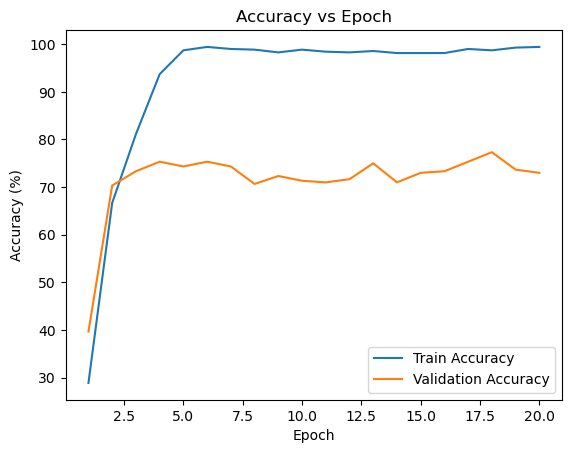

Final Validation Accuracy: 73.00%


In [15]:
import os
import gc
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Base directory containing genre folders
data_dir = r'C:\Users\ykj2\Desktop\Data\genres_original'

# List to store all file paths and their genres
data_pairs = []

# Iterate through each genre folder
for genre in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            if file.endswith(('.wav', '.mp3')):
                data_pairs.append((file_path, genre))  # Add file path and genre

# Print the collected file paths and their genres
for path, genre in data_pairs:
    print(f"File: {path}, Genre: {genre}")

# Function to convert audio to Mel-spectrogram
def audio_to_melspectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram)
    return log_spectrogram

# Dictionary to store Mel-spectrograms for each genre
spectrogram_dict = {}

# Assume data_pairs is a list of (file_path, genre) tuples
for file_path, genre in data_pairs:
    try:
        # Convert audio to Mel-spectrogram and normalize to [0, 1]
        spectrogram = audio_to_melspectrogram(file_path)
        spectrogram_normalized = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        
        # Accumulate results in dictionary
        if genre not in spectrogram_dict:
            spectrogram_dict[genre] = []
        spectrogram_dict[genre].append(spectrogram_normalized)
    
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

# Verify results
for genre, features in spectrogram_dict.items():
    print(f"Genre: {genre}, Number of Files Processed: {len(features)}")

# Define genre-to-index mapping
genre_to_idx = {genre: idx for idx, genre in enumerate(spectrogram_dict.keys())}

# Prepare data list from the dictionary of Mel-spectrograms
data_list = []
for genre, spectrogram_list in spectrogram_dict.items():
    for spectrogram_data in spectrogram_list:
        data_list.append((spectrogram_data, genre_to_idx[genre]))

# Split the data into train and validation sets with stratification
labels = [label for _, label in data_list]
train_data, val_data = train_test_split(data_list, test_size=1-train_split, stratify=labels)

# Example parameters
batch_size = 16
train_split = 0.8  # Train-test split ratio

# Transformations for ResNet152
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet152 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset for Mel-spectrogram data
class SpectrogramDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = [item[0] for item in data_list]  # Spectrograms
        self.labels = [item[1] for item in data_list]  # Genres
        self.transform = transform

        # Map genres to numeric indices
        unique_labels = sorted(set(self.labels))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        spectrogram_image = self.data[idx]
        label = self.labels[idx]
        
        # Convert Mel-spectrogram to PIL Image and scale to RGB format
        spectrogram_image = np.stack([spectrogram_image] * 3, axis=-1)  # Convert to RGB
        
        spectrogram_image = Image.fromarray((spectrogram_image * 255).astype('uint8')).convert('RGB')
        
        if self.transform:
            spectrogram_image = self.transform(spectrogram_image)
        
        return spectrogram_image, label


# Create Dataset and DataLoader instances
train_dataset = SpectrogramDataset(train_data, transform=transform)
val_dataset = SpectrogramDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize ResNet152 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(genre_to_idx))  # Adjust output for genres
model = model.to(device)

# Loss function and optimizer with a lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and validation function
def train_and_evaluate(num_epochs):
    train_accuracies, val_accuracies, total_train_loss, total_val_loss = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        train_loss = 0.00
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            train_loss += loss.item()
        
        train_accuracy = 100 * correct / total
        train_loss /= len(train_loader)
        train_accuracies.append(train_accuracy)
        total_train_loss.append(train_loss)
             
        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        val_loss = 0.00
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                val_loss += loss.item()
                total += labels.size(0)
        
        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        val_accuracies.append(val_accuracy)
        total_val_loss.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_accuracies, val_accuracies, total_val_loss, total_train_loss

# Train the model
num_epochs = 20  # Set the desired number of epochs
train_accuracies, val_accuracies, total_val_loss, total_train_loss = train_and_evaluate(num_epochs)

# Plot accuracies over epochs
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# Print final validation accuracy
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")


In [ ]:
# Plot accuracies over epochs
plt.plot(range(1, num_epochs+1), total_val_loss, label=' Validation Loss')
plt.plot(range(1, num_epochs+1), total_train_loss, label=' Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.fft import fft
import librosa

# Function to compute FFT and normalize
def compute_fft(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    fft_features = np.abs(fft(audio))  # Compute FFT magnitude spectrum
    fft_features = (fft_features - fft_features.min()) / (fft_features.max() - fft_features.min())  # Normalize to [0, 1]
    return fft_features

# Dictionary to store FFT features for each genre
fft_dict = {}

# Assume data_pairs is a list of (file_path, genre) tuples
for file_path, genre in data_pairs:
    try:
        # Compute FFT features
        fft_features = compute_fft(file_path)
        
        # Accumulate results in dictionary
        if genre not in fft_dict:
            fft_dict[genre] = []
        fft_dict[genre].append(fft_features)
    
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

# Verify results
for genre, features in fft_dict.items():
    print(f"Genre: {genre}, Number of Files Processed: {len(features)}")

# Example parameters
batch_size = 32
train_split = 0.8  # Train-test split ratio

# Transformations for ResNet50 (Resizing and Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset for FFT data
class FFTDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = [item[0] for item in data_list]  # FFT features
        self.labels = [item[1] for item in data_list]  # Genres
        self.transform = transform

        # Map genres to numeric indices
        unique_labels = sorted(set(self.labels))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fft_image = self.data[idx]
        label = self.labels[idx]
        
        # Reshape FFT feature into a square image and convert to RGB format (ResNet50 requires RGB images)
        size = int(np.ceil(np.sqrt(len(fft_image))))  # Determine the size of the square image
        padded_fft = np.zeros(size**2)  # Pad with zeros if necessary to make it square
        padded_fft[:len(fft_image)] = fft_image  # Copy FFT values into the padded array
        
        fft_image_2d = padded_fft.reshape(size, size)  # Reshape into a square matrix
        
        # Convert to PIL Image and scale to RGB format (3 channels)
        fft_image_rgb = Image.fromarray((fft_image_2d * 255).astype('uint8')).convert('RGB')
        
        if self.transform:
            fft_image_rgb = self.transform(fft_image_rgb)
        
        return fft_image_rgb, label

# Prepare data list from the dictionary of FFT features
data_list = []
for genre, fft_list in fft_dict.items():
    for fft_data in fft_list:
        data_list.append((fft_data, genre))

# Split the data into train and validation sets with stratification
labels = [label for _, label in data_list]
train_data, val_data = train_test_split(data_list, test_size=1-train_split, stratify=labels)

# Create Dataset and DataLoader instances
train_dataset = FFTDataset(train_data, transform=transform)
val_dataset = FFTDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize ResNet50 model with adjusted output layer for genres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.label_to_idx))  # Adjust output for genres
model = model.to(device)

# Loss function and optimizer with a lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and validation function
def train_and_evaluate(num_epochs):
    train_accuracies, val_accuracies, total_val_loss, total_train_loss = [], [] , [] , []
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        train_loss = 0.00
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_accuracy = 100 * correct / total
        train_loss += loss.item()
        train_accuracies.append(train_accuracy)
        
        train_loss /= len(train_loader)
        total_train_loss.append(train_loss)

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        val_loss = 0.00
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = 100 * correct / total
        val_loss += loss.item()
        val_accuracies.append(val_accuracy)
        
        val_loss /= len(val_loader)
        total_val_loss.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs},  Train Loss:{train_loss:.4f}, Val Loss:{val_loss:.4f} Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_accuracies, val_accuracies, total_val_loss, total_train_loss

# Train the model
num_epochs = 50  # Set the desired number of epochs
train_accuracies, val_accuracies, total_val_loss, total_train_loss = train_and_evaluate(num_epochs)

# Plot accuracies over epochs
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# Print final validation accuracy
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")


In [ ]:
# Plot accuracies over epochs
plt.plot(range(1, num_epochs+1), total_val_loss, label=' Validation Loss')
plt.plot(range(1, num_epochs+1), total_train_loss, label=' Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()